 ### Supervised Learning Model for Motor Movement Prediction using Brain-Computer Interfaces

#### Load and Explore the EDF File

In [65]:
import os
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

# List of files to process
edf_files = ["S001R01.edf","S001R02.edf", "S001R03.edf", "S001R04.edf","S001R05.edf","S001R06.edf","S001R07.edf","S001R08.edf","S001R09.edf","S001R10.edf","S001R11.edf","S001R12.edf","S001R13.edf","S001R14.edf"]

#### Defining Bandpass Filter for EEG Preprocessing

In [66]:
# Define bandpass filter function
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, data, axis=1)

#### Initializing Storage for Merging Data

In [67]:
# Initialize empty lists for storing EEG data, labels, and session tracking
all_eeg_data = []
all_labels = []
all_sessions = []

#### Process Each EEG File

In [68]:
for edf_file in edf_files:
    print(f"Processing {edf_file}...")

    # Load EEG data from file
    raw = mne.io.read_raw_edf(edf_file, preload=True)
    events, event_dict = mne.events_from_annotations(raw)

    # Print EEG metadata
    print(raw.info)

    # Plot EEG signals (first 10 channels, 5 seconds)
    #raw.plot(duration=5, n_channels=10)

    # Apply bandpass filter (1-40 Hz)
    filtered_data = butter_bandpass_filter(raw.get_data(), lowcut=1, highcut=40, fs=raw.info['sfreq'])

    # Store EEG and labels
    all_eeg_data.append(filtered_data)
    all_labels.append(events)
    all_sessions.append(np.full((filtered_data.shape[1],), edf_file))  # Track session

Processing S001R01.edf...
Extracting EDF parameters from c:\Users\angom\East Tennessee State University\Applied Data Science - AB - Documentos\Courses\Machine Learning\Project\EEG-Based Motor Intention Prediction\S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Used Annotations descriptions: ['T0']
<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>
Processing S001R02.edf...
Extracting EDF parameters from c:\Users\angom\East Tennessee State University\Applied Data Science - AB - Documentos\Courses\Machine Learning\Project\EEG-Based Motor Intention Prediction\S001R02.edf...
EDF file detected
Setting channel info 

#### Merge All EEG Data Into One Dataset

In [69]:
# Concatenate EEG data from all sessions
merged_eeg = np.hstack(all_eeg_data)  # Merge along time axis
merged_sessions = np.concatenate(all_sessions)  # Merge session info

# Print shape of merged EEG dataset
print(f"Merged EEG Data Shape: {merged_eeg.shape}")  # (n_channels, total_time_samples)

Merged EEG Data Shape: (64, 259520)


#### Convert to DataFrame & Assign Labels

In [70]:
# Convert EEG data to DataFrame
df = pd.DataFrame(merged_eeg.T, columns=raw.ch_names)  # Transpose so rows = time samples

# Initialize movement labels (default = 0)
df["Movement_Label"] = 0

# Assign correct movement labels from event data
for i, event_list in enumerate(all_labels):
    for event in event_list:
        sample_idx, _, label = event
        df.loc[sample_idx:, "Movement_Label"] = label  # Assign labels at event points

# Add session info for tracking
df["Session"] = merged_sessions

#### Visualize Merged EEG Data

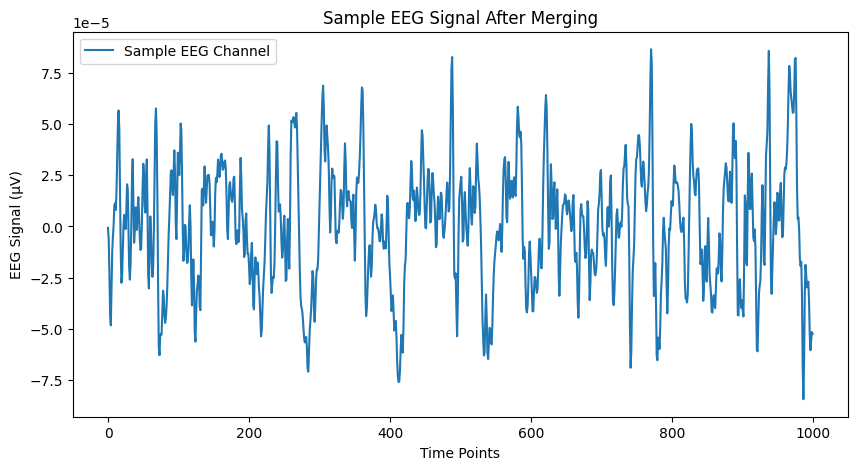

In [71]:
plt.figure(figsize=(10, 5))
plt.plot(df.iloc[:1000, 0], label="Sample EEG Channel")  # Plot first channel
plt.xlabel("Time Points")
plt.ylabel("EEG Signal (µV)")
plt.title("Sample EEG Signal After Merging")
plt.legend()
plt.show()

#### Checking how many samples are labeled as T0, T1, and T2.

In [72]:
print(df["Movement_Label"].value_counts())

Movement_Label
3    244848
1     10080
2      4592
Name: count, dtype: int64


T0 (Rest) 

T1 (Movement) 

T2 (Movement)

#### Save Merged Data to CSV

In [73]:
# Save merged dataset as CSV
df.to_csv("merged_eeg_data.csv", index=False)

print("Merged EEG data saved as merged_eeg_data.csv")

Merged EEG data saved as merged_eeg_data.csv


#### Feature extraction

In [74]:
# Import necessary libraries
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.signal import welch
from scipy.fft import fft
from mne.decoding import CSP  # Common Spatial Patterns


***Load Preprocessed EEG Data***

In [75]:
# Load the preprocessed EEG dataset
df = pd.read_csv("merged_eeg_data.csv")

# Separate EEG signals (features) and movement labels (targets)
X = df.iloc[:, :-2].values  # All EEG channels
y = df["Movement_Label"].values  # Movement labels
channels = df.columns[:-2]  # EEG channel names

***Compute Time-Domain Features***

In [76]:
def hjorth_parameters(eeg_signal):
    """ Compute Hjorth parameters: Activity, Mobility, Complexity """
    first_derivative = np.diff(eeg_signal)
    second_derivative = np.diff(first_derivative)

    activity = np.var(eeg_signal)
    mobility = np.sqrt(np.var(first_derivative) / activity)
    complexity = np.sqrt(np.var(second_derivative) / np.var(first_derivative))

    return activity, mobility, complexity

# Compute time-domain features for each channel
time_features = []

for i in range(X.shape[1]):  # Loop over channels
    channel_data = X[:, i]

    mean_val = np.mean(channel_data)
    variance_val = np.var(channel_data)
    rms_val = np.sqrt(np.mean(channel_data**2))
    hjorth_act, hjorth_mob, hjorth_comp = hjorth_parameters(channel_data)

    time_features.append([mean_val, variance_val, rms_val, hjorth_act, hjorth_mob, hjorth_comp])

# Convert to DataFrame
time_features_df = pd.DataFrame(time_features, columns=["Mean", "Variance", "RMS", "Hjorth_Activity", "Hjorth_Mobility", "Hjorth_Complexity"], index=channels)

# Display the first few rows of the DataFrame
print("Time-Domain Features:")
display(time_features_df)

# Save it as CSV for later use
time_features_df.to_csv("time_domain_features.csv", index=True)
print("Time-domain features saved as time_domain_features.csv")


Time-Domain Features:


,Mean,Variance,RMS,Hjorth_Activity,Hjorth_Mobility,Hjorth_Complexity
Fc5.,1.797835e-09,1.392376e-09,0.000037,1.392376e-09,0.379161,0.904884
Fc3.,3.999856e-09,1.571847e-09,0.000040,1.571847e-09,0.374726,0.868747
Fc1.,5.282795e-09,1.664740e-09,0.000041,1.664740e-09,0.369925,0.863995
Fcz.,5.262436e-09,1.697423e-09,0.000041,1.697423e-09,0.370282,0.870795
Fc2.,5.365883e-09,1.581690e-09,0.000040,1.581690e-09,0.364133,0.863761
...,...,...,...,...,...,...
Po8.,2.675919e-09,1.547473e-09,0.000039,1.547473e-09,0.418583,0.871816
O1..,1.977031e-09,1.889173e-09,0.000043,1.889173e-09,0.415315,0.791015
Oz..,2.291164e-09,1.780555e-09,0.000042,1.780555e-09,0.425377,0.825722
O2..,2.318118e-10,1.911486e-09,0.000044,1.911486e-09,0.435735,0.840531


Time-domain features saved as time_domain_features.csv


***Compute Frequency-Domain Features***

In [77]:
def compute_psd(signal, fs=160):
    """ Compute Power Spectral Density (PSD) using Welch's method """
    freqs, psd_values = welch(signal, fs, nperseg=fs*2)
    return np.mean(psd_values)  # Return mean PSD as feature

# Compute FFT and PSD for each EEG channel
freq_features = []

for i in range(X.shape[1]):
    channel_data = X[:, i]

    # Compute FFT magnitude
    fft_vals = np.abs(fft(channel_data))
    fft_mean = np.mean(fft_vals)

    # Compute PSD
    psd_mean = compute_psd(channel_data)

    freq_features.append([fft_mean, psd_mean])

# Convert to DataFrame
freq_features_df = pd.DataFrame(freq_features, columns=["FFT_Mean", "PSD_Mean"], index=channels)

# Display Frequency-Domain Features
print("Frequency-Domain Features:")
display(freq_features_df)
freq_features_df.to_csv("frequency_domain_features.csv", index=True)
print("Frequency-domain features saved as frequency_domain_features.csv")


Frequency-Domain Features:


,FFT_Mean,PSD_Mean
Fc5.,0.009346,1.736607e-11
Fc3.,0.009873,1.957427e-11
Fc1.,0.010110,2.072260e-11
Fcz.,0.010212,2.112777e-11
Fc2.,0.009763,1.969295e-11
...,...,...
Po8.,0.010306,1.925636e-11
O1..,0.011219,2.354088e-11
Oz..,0.011027,2.217832e-11
O2..,0.011524,2.381326e-11


Frequency-domain features saved as frequency_domain_features.csv


***Compute Spatial Features (CSP)***

In [78]:
from mne.decoding import CSP

# Define trial length (e.g., 2 seconds per trial)
sfreq = 160  # Sampling frequency (Hz)
trial_length = 2  # Seconds
samples_per_trial = sfreq * trial_length  # Number of time points per trial

# Compute number of trials available
num_trials = X.shape[0] // samples_per_trial

# Reshape EEG data into (trials, channels, time_samples)
X_trials = X[:num_trials * samples_per_trial].reshape(num_trials, len(channels), samples_per_trial)

# Reshape labels (assign label per trial)
y_trials = y[:num_trials * samples_per_trial:samples_per_trial]

# Ensure labels match the number of trials
if X_trials.shape[0] != len(y_trials):
    raise ValueError("Mismatch in number of trials and labels!")

# Apply CSP
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
X_csp = csp.fit_transform(X_trials, y_trials)

# Convert to DataFrame
csp_df = pd.DataFrame(X_csp, columns=[f"CSP_{i+1}" for i in range(4)])

# Display CSP features
print("Spatial Features (CSP):")
display(csp_df)
csp_df.to_csv("spatial_features_csp.csv", index=True)
print("CSP features saved as spatial_features_csp.csv")

Computing rank from data with rank=None
    Using tolerance 0.0007 (2.2e-16 eps * 64 dim * 4.9e+10  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=2 covariance using EMPIRICAL
Done.
Estimating class=3 covariance using EMPIRICAL
Done.
Spatial Features (CSP):


,CSP_1,CSP_2,CSP_3,CSP_4
0,1.410137,-0.012942,0.452165,-0.079736
1,-1.374448,-1.669766,-0.445234,-0.565924
2,-0.983941,-1.793387,-1.152006,0.013214
3,-1.556008,-0.862441,-0.931907,0.125074
4,0.234655,-0.312729,0.421353,0.769606
...,...,...,...,...
806,0.812219,-1.094242,-0.772911,0.424880
807,1.586878,0.016436,0.338809,0.291534
808,-0.259507,-0.700443,0.193675,-0.219454
809,-0.808187,-0.925661,0.006167,-0.006952


CSP features saved as spatial_features_csp.csv


#### Merging All Features into a Single Dataset for Model Training

***Load All Extracted Feature Files***

In [79]:
import pandas as pd

# Load extracted features
time_features = pd.read_csv("time_domain_features.csv", index_col=0)  # Time-domain features
freq_features = pd.read_csv("frequency_domain_features.csv", index_col=0)  # Frequency-domain features
csp_features = pd.read_csv("spatial_features_csp.csv", index_col=0)  # CSP features

# Display shapes
print(f"Time Features Shape: {time_features.shape}")
print(f"Frequency Features Shape: {freq_features.shape}")
print(f"CSP Features Shape: {csp_features.shape}")

Time Features Shape: (64, 6)
Frequency Features Shape: (64, 2)
CSP Features Shape: (811, 4)


***Merge Features***

In [80]:
# Merge time & frequency features (both have 64 channels)
merged_static_features = pd.concat([time_features, freq_features], axis=1)

# Repeat static features for each CSP trial to match dimensions
merged_static_features_expanded = pd.concat([merged_static_features] * (csp_features.shape[0] // merged_static_features.shape[0]), ignore_index=True)

# Merge with CSP features
final_features = pd.concat([merged_static_features_expanded, csp_features], axis=1)

# Display shape
print(f"Final Features Shape: {final_features.shape}")

Final Features Shape: (811, 12)


***Adding Movement Labels***

In [81]:
# Load labels from the original EEG dataset
df = pd.read_csv("merged_eeg_data.csv")

# Extract movement labels per trial
sfreq = 160  # Sampling frequency
trial_length = 2  # Seconds
samples_per_trial = sfreq * trial_length

# Extract labels (one per trial)
num_trials = final_features.shape[0]
movement_labels = df["Movement_Label"].values[:num_trials * samples_per_trial:samples_per_trial]

# Attach labels to final dataset
final_features["Movement_Label"] = movement_labels

# Show preview
print(final_features.head())

           Mean      Variance       RMS  Hjorth_Activity  Hjorth_Mobility  \
0  1.797835e-09  1.392376e-09  0.000037     1.392376e-09         0.379161   
1  3.999856e-09  1.571847e-09  0.000040     1.571847e-09         0.374726   
2  5.282795e-09  1.664740e-09  0.000041     1.664740e-09         0.369925   
3  5.262436e-09  1.697423e-09  0.000041     1.697423e-09         0.370282   
4  5.365883e-09  1.581690e-09  0.000040     1.581690e-09         0.364133   

   Hjorth_Complexity  FFT_Mean      PSD_Mean     CSP_1     CSP_2     CSP_3  \
0           0.904884  0.009346  1.736607e-11  1.410137 -0.012942  0.452165   
1           0.868747  0.009873  1.957427e-11 -1.374448 -1.669766 -0.445234   
2           0.863995  0.010110  2.072260e-11 -0.983941 -1.793387 -1.152006   
3           0.870795  0.010212  2.112777e-11 -1.556008 -0.862441 -0.931907   
4           0.863761  0.009763  1.969295e-11  0.234655 -0.312729  0.421353   

      CSP_4  Movement_Label  
0 -0.079736               1  
1 -0.565

***Saving Final Dataset***

In [82]:
# Save the merged dataset for ML training
final_features.to_csv("final_features.csv", index=False)

print("Final dataset saved as final_features.csv")

Final dataset saved as final_features.csv


#### Feature scaling

In [83]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Load final dataset
df = pd.read_csv("final_features.csv")

# Separate features and labels
X = df.drop(columns=["Movement_Label"])  # Features
y = df["Movement_Label"]  # Labels

# Applying Standard Scaling (Mean=0, Variance=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame
scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
scaled_df["Movement_Label"] = y  # Reattach labels

# Display shape to verify
print(f"Scaled Dataset Shape: {scaled_df.shape}")

# Save scaled dataset for training
scaled_df.to_csv("scaled_final_features.csv", index=False)

print("Scaled dataset saved as scaled_final_features.csv")

Scaled Dataset Shape: (811, 13)
Scaled dataset saved as scaled_final_features.csv


#### Class Distribution Check (Detecting Imbalance)

Checking how many samples belong to each movement class (T0, T1, T2):

Class Distribution:
Movement_Label
3    764
1     32
2     15
Name: count, dtype: int64


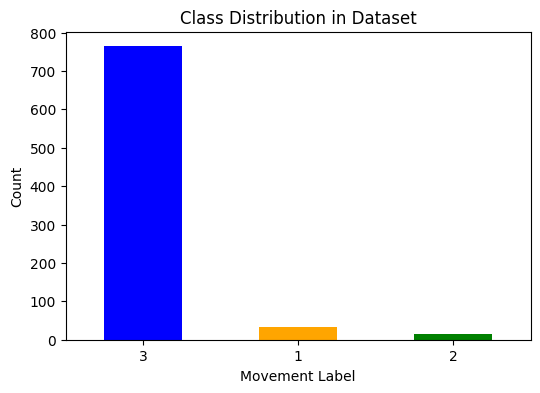

In [84]:
import pandas as pd

# Load scaled dataset
scaled_df = pd.read_csv("scaled_final_features.csv")

# Count occurrences of each movement label
class_counts = scaled_df["Movement_Label"].value_counts()

# Display class distribution
print("Class Distribution:")
print(class_counts)

# Visualize class balance
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
class_counts.plot(kind="bar", color=["blue", "orange", "green"])
plt.xlabel("Movement Label")
plt.ylabel("Count")
plt.title("Class Distribution in Dataset")
plt.xticks(rotation=0)
plt.show()

The dataset is imbalanced at this point. This could lead to biased models favoring the majority class (class 2).

So, we will Consider handling this imbalance by using oversampling: SMOTE (Synthetic Minority Over-sampling Technique) to generate synthetic samples. Or Class Weights in model training to balance the effect of underrepresented classes.

#### Handling Class Imbalance with SMOTE (Synthetic Minority Over-sampling Technique)

Used to balance the classes, and prevent models from being biased toward the majority class, which can happen when the dataset is highly imbalanced.

Generates synthetic samples for underrepresented classes by interpolating between existing minority class instances.

We first need to double check if we have any missing values since SMOTE can fail if the dataset contains NaN (missing) values.

In [85]:
import pandas as pd

# Load the dataset
df = pd.read_csv("scaled_final_features.csv")

# Count missing values per column
missing_counts = df.isnull().sum()

# Display only columns with missing values
missing_counts = missing_counts[missing_counts > 0]

if missing_counts.empty:
    print("No missing values in the dataset!")
else:
    print("Missing Values Detected:")
    print(missing_counts)

Missing Values Detected:
Mean                 43
Variance             43
RMS                  43
Hjorth_Activity      43
Hjorth_Mobility      43
Hjorth_Complexity    43
FFT_Mean             43
PSD_Mean             43
dtype: int64


In [86]:
from sklearn.impute import SimpleImputer
import pandas as pd

# Load the dataset
df = pd.read_csv("scaled_final_features.csv")

# Impute missing values using mean
imputer = SimpleImputer(strategy="mean")
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Save cleaned dataset
df_imputed.to_csv("cleaned_final_features.csv", index=False)

print("Cleaned dataset saved as cleaned_final_features.csv")

Cleaned dataset saved as cleaned_final_features.csv


In [87]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Load the cleaned dataset (after handling missing values)
df = pd.read_csv("cleaned_final_features.csv")

# Separate features and labels
X = df.drop(columns=["Movement_Label"])
y = df["Movement_Label"]

# Apply SMOTE to balance the classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert back to DataFrame
balanced_df = pd.DataFrame(X_resampled, columns=X.columns)
balanced_df["Movement_Label"] = y_resampled  # Add the balanced labels

# Save the balanced dataset
balanced_df.to_csv("balanced_final_features.csv", index=False)

print("Balanced dataset saved as balanced_final_features.csv")

Balanced dataset saved as balanced_final_features.csv


***Checking the class distribution again to confirm that SMOTE worked.***

In [88]:
print("New Class Distribution:")
print(balanced_df["Movement_Label"].value_counts())

New Class Distribution:
Movement_Label
1.0    764
3.0    764
2.0    764
Name: count, dtype: int64


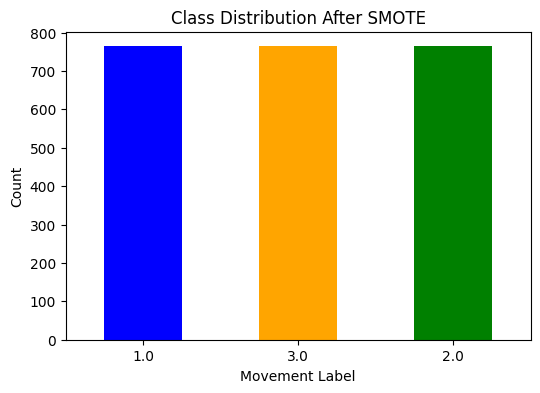

In [89]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the balanced dataset
balanced_df = pd.read_csv("balanced_final_features.csv")

# Plot the class distribution after SMOTE
plt.figure(figsize=(6, 4))
balanced_df["Movement_Label"].value_counts().plot(kind="bar", color=["blue", "orange", "green"])
plt.xlabel("Movement Label")
plt.ylabel("Count")
plt.title("Class Distribution After SMOTE")
plt.xticks(rotation=0)
plt.show()

##### Feature Importance Using Random Forest

Feature Importance Ranking:
              Feature  Importance
9               CSP_2    0.254497
8               CSP_1    0.212613
11              CSP_4    0.201421
10              CSP_3    0.110333
0                Mean    0.031731
4     Hjorth_Mobility    0.029934
7            PSD_Mean    0.029273
6            FFT_Mean    0.029125
5   Hjorth_Complexity    0.028022
1            Variance    0.025911
3     Hjorth_Activity    0.023851
2                 RMS    0.023289


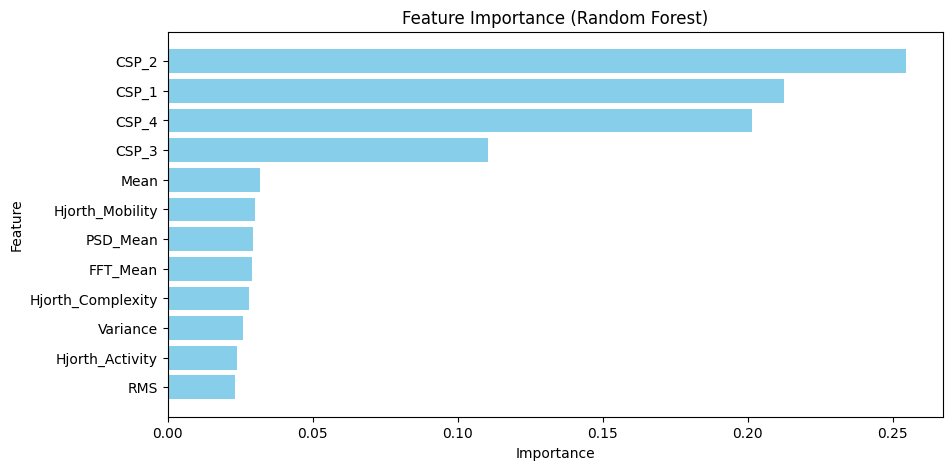

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np

# Separate features and labels
X = scaled_df.drop(columns=["Movement_Label"])  # Features
y = scaled_df["Movement_Label"]  # Labels

# Split dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importance
feature_importance = rf.feature_importances_

# Convert to DataFrame for visualization
importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Display feature importance
print("Feature Importance Ranking:")
print(importance_df)

# Visualize feature importance
plt.figure(figsize=(10, 5))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (Random Forest)")
plt.gca().invert_yaxis()  # Highest importance at top
plt.show()

Features CSP_4, CSP_1, CSP_2, and CSP_3 contribute most to distinguishing movement labels.

Hjorth Mobility is also relatively influential, indicating its significance in EEG signal variability.

Other features have lower impact, but still contribute.

#### Working only for the Action Data (The subject actually made a movement)

#### Splitting the data into Training & Testing sets 

In [91]:
from sklearn.model_selection import train_test_split

# Load the balanced dataset
balanced_df = pd.read_csv("balanced_final_features.csv")

# Separate features and labels
X = balanced_df.drop(columns=["Movement_Label"])
y = balanced_df["Movement_Label"]

# Split into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Save the split datasets
X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

print("Data split into training and testing sets.")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Data split into training and testing sets.
Training set shape: (1833, 12)
Testing set shape: (459, 12)


Training a Machine Learning Model (1st try with Random Forest Classifier)

Training Accuracy: 1.0000
Testing Accuracy: 0.9913

Classification Report (Test Set):
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       611
         2.0       1.00      1.00      1.00       611
         3.0       1.00      1.00      1.00       611

    accuracy                           1.00      1833
   macro avg       1.00      1.00      1.00      1833
weighted avg       1.00      1.00      1.00      1833


Classification Report (Test Set):
              precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       153
         2.0       0.99      1.00      1.00       153
         3.0       0.99      0.99      0.99       153

    accuracy                           0.99       459
   macro avg       0.99      0.99      0.99       459
weighted avg       0.99      0.99      0.99       459



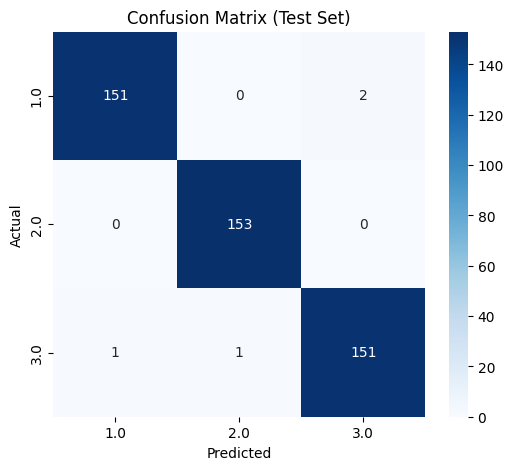

In [92]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on training and testing sets
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Evaluate the model on training and testing sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Classification report for test set
print("\nClassification Report (Test Set):")
print(classification_report(y_train, y_train_pred))

# Classification report for test set
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

# Confusion matrix for test set
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Set)")
plt.show()


C:\Users\angom\AppData\Local\Temp\ipykernel_18244\3555022966.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Training Accuracy", "Testing Accuracy"], y=[train_accuracy, test_accuracy], palette=["green", "blue"])


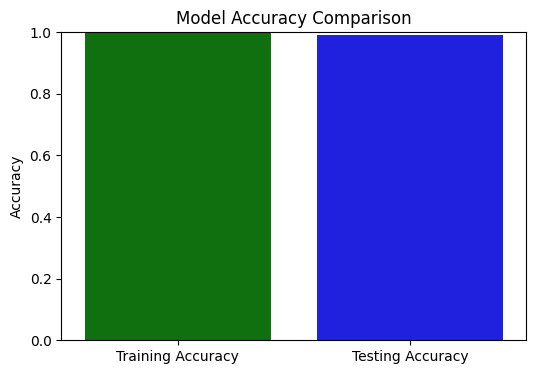

In [93]:
# Plot Training vs Testing Accuracy
plt.figure(figsize=(6, 4))
sns.barplot(x=["Training Accuracy", "Testing Accuracy"], y=[train_accuracy, test_accuracy], palette=["green", "blue"])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()

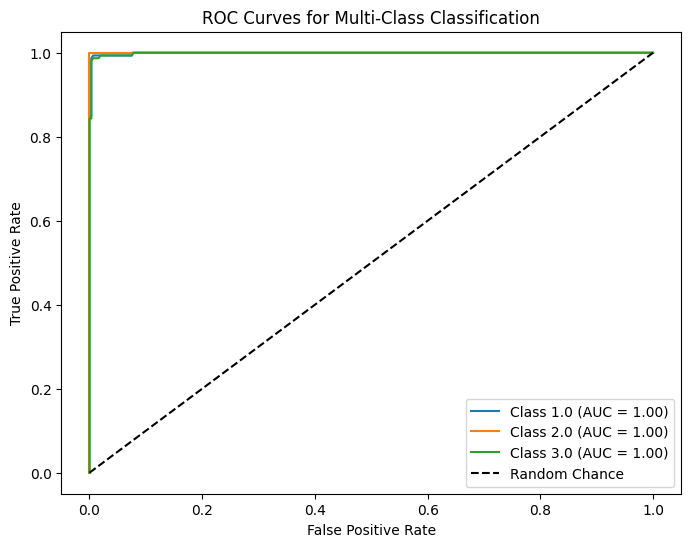

In [94]:
from sklearn.metrics import roc_curve, auc  # Import ROC functions

# Plot ROC Curves for Multi-Class Classification
plt.figure(figsize=(8, 6))
for i in range(len(rf_model.classes_)):
    fpr, tpr, _ = roc_curve(y_test == rf_model.classes_[i], rf_model.predict_proba(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {rf_model.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Multi-Class Classification")
plt.legend()
plt.show()

#### Applying Probabilistic Common Spatial Patterns (P-CSP)

In [123]:
# %% [markdown]
# ### Applying Probabilistic Common Spatial Patterns (P-CSP)

# %% [markdown]
# #### Load Raw EEG Data from `merged_eeg_data.csv`

# %%
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.decomposition import FastICA
from sklearn.model_selection import train_test_split
from mne.decoding import CSP

# Load the raw EEG dataset
df = pd.read_csv("merged_eeg_data.csv")

# Extract EEG signals (features) and movement labels
X = df.iloc[:, :-2].values  # EEG channel data
y = df["Movement_Label"].values  # Movement labels
channels = df.columns[:-2]

# Define parameters
sfreq = 160  # Sampling frequency (Hz)
trial_length = 2  # Seconds per trial
samples_per_trial = sfreq * trial_length  # Total samples per trial

# Compute number of trials
num_trials = X.shape[0] // samples_per_trial

# Reshape EEG data into (trials, channels, time_samples)
X_trials = X[:num_trials * samples_per_trial].reshape(num_trials, len(channels), samples_per_trial)

# Assign labels per trial (ensure correct slicing)
y_trials = y[:num_trials * samples_per_trial:samples_per_trial]

print(f"P-CSP Input Shape: {X_trials.shape} (Trials, Channels, Time Samples)")

# %% [markdown]
# #### Implement Probabilistic CSP (P-CSP)

# %%
class ProbabilisticCSP:
    def __init__(self, n_components=4, reg_param=0.1, sparse=False):
        self.n_components = n_components
        self.reg_param = reg_param  # Regularization parameter (for TR-CSP)
        self.sparse = sparse  # If True, apply L1 regularization
        self.A = None  # Mixing matrix
        self.Z = None  # Source signals

    def fit(self, X, y):
        """
        Fit the P-CSP model using variational Bayesian inference.
        X: EEG data (trials, channels, time_samples)
        y: Movement labels
        """
        trials, channels, time_samples = X.shape

        # Compute covariance matrices per class
        cov_matrices = {}
        for label in np.unique(y):
            class_trials = X[y == label]  # Fix: Properly select class-specific trials
            if class_trials.shape[0] > 1:  # Ensure enough samples exist
                cov_matrices[label] = np.mean([np.cov(trial) for trial in class_trials], axis=0)

        # Compute composite covariance matrix
        if len(cov_matrices) > 0:
            cov_avg = np.mean(list(cov_matrices.values()), axis=0)
        else:
            raise ValueError("Covariance matrices could not be computed. Check class distribution.")

        # Solve the generalized eigenvalue problem
        eigvals, eigvecs = np.linalg.eigh(cov_avg)

        # Select the top n_components spatial filters (ensure proper indexing)
        self.A = eigvecs[:, -self.n_components:].copy()

        # Compute projected sources (Z_k)
        self.Z = np.array([np.dot(self.A.T, trial) for trial in X])

        # Apply Bayesian regularization
        if self.sparse:
            self.Z = np.sign(self.Z) * np.maximum(0, np.abs(self.Z) - self.reg_param)

        print("P-CSP Training Complete.")

    def transform(self, X):
        """
        Project new EEG data using trained spatial filters.
        """
        return np.array([np.dot(self.A.T, trial) for trial in X])

# %% [markdown]
# #### Train P-CSP on Raw EEG Trials

# %%
# Initialize and apply P-CSP
p_csp = ProbabilisticCSP(n_components=4, reg_param=0.1, sparse=True)
p_csp.fit(X_trials, y_trials)

# Transform the EEG signals into spatial features
X_p_csp = p_csp.transform(X_trials)

# Ensure proper reshaping for DataFrame conversion
num_features = X_p_csp.shape[1] * X_p_csp.shape[2]
X_p_csp_reshaped = X_p_csp.reshape(X_p_csp.shape[0], num_features)

# Convert to DataFrame
p_csp_df = pd.DataFrame(X_p_csp_reshaped, 
                         columns=[f"P-CSP_{i+1}" for i in range(num_features)])

# Save the new features
p_csp_df["Movement_Label"] = y_trials
p_csp_df.to_csv("p_csp_features.csv", index=False)

print("P-CSP features saved as p_csp_features.csv")

# %% [markdown]
# #### Train a Classifier Using P-CSP Features

# %%
# Load P-CSP transformed features
df_p_csp = pd.read_csv("p_csp_features.csv")

# Separate features and labels
X_p_csp = df_p_csp.drop(columns=["Movement_Label"])
y_p_csp = df_p_csp["Movement_Label"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_p_csp, y_p_csp, test_size=0.2, random_state=42, stratify=y_p_csp)

# Train a classifier (Random Forest)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Compute balanced class weights
unique_classes = np.unique(y_train)
class_weights = compute_class_weight("balanced", classes=unique_classes, y=y_train)
weights_dict = {unique_classes[i]: class_weights[i] for i in range(len(unique_classes))}  # Fix: Corrected dictionary indexing

# Train Random Forest with class weights
rf_p_csp = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=weights_dict)
rf_p_csp.fit(X_train, y_train)

# Predict
y_pred_train = rf_p_csp.predict(X_train)
y_pred_test = rf_p_csp.predict(X_test)

# Evaluate
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"P-CSP Training Accuracy: {train_acc:.4f}")
print(f"P-CSP Testing Accuracy: {test_acc:.4f}")

print("\nClassification Report (P-CSP - Test Set):")
print(classification_report(y_test, y_pred_test))

# %% [markdown]
# ### P-CSP Successfully Applied!


P-CSP Input Shape: (811, 64, 320) (Trials, Channels, Time Samples)
P-CSP Training Complete.
P-CSP features saved as p_csp_features.csv
P-CSP Training Accuracy: 1.0000
P-CSP Testing Accuracy: 0.9448

Classification Report (P-CSP - Test Set):
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         3
           3       0.94      1.00      0.97       154

    accuracy                           0.94       163
   macro avg       0.31      0.33      0.32       163
weighted avg       0.89      0.94      0.92       163



c:\Users\angom\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\angom\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\angom\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo